### Create stratified-random sample to use as Test Data

In this script, we aim to use stratified sampling to create a testing set for classification that reflects the distribution of the original dataset.

Steps:
- Explore the distribution of respondents according to main characteristics.
- Calculate VADER-based sentiment polarity scores
- Create stratified random sample to use as test data
- Add TextBlob sentiment polarity scores
- Compare results

### 1. Imports and Set Up

In [107]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [108]:
#### Set up working directory

cwd = os.chdir('/Users/alessia/Documents/DataScience/NLP_Project/Outputs')

In [109]:
pd.set_option('display.max_colwidth', -1)

### 2. Get Data

In [110]:
# Read in data (note header is spread over two rows)

cons1_df = pd.read_csv("cons1_df.csv")

In [111]:
# Explore data

#[print(str(num) + ' = ' + question) for num, question in enumerate(cons1_df.columns)]

Key characteristics seem to be in columns:
- 10 organisation vs. individual
- 18 Public sector (also check 19)
- 20 Private sector (also check 21)
- 22 Other sectors

Secondary characteristics we may want to look at:
- 24-39 Type of use of pop and housing statstics

### 3. Explore distribution of main characteristics

In [112]:
# 10 = Are you responding on behalf of an organisation, or as an individual?Response

print("Number of NaN: {}".format(cons1_df.iloc[:, 10].isnull().sum()))
print(cons1_df.iloc[:, 10].value_counts())

Number of NaN: 23
Individual      811
Organisation    274
Name: Are you responding on behalf of an organisation, or as an individual?Response, dtype: int64


In [113]:
# 18 Public Sector
#print("Number of NaN in Public sector: {}".format(cons1_df.iloc[:, 18].isnull().sum()))
#print(cons1_df.iloc[:, 18].value_counts())

# 19 Public Sector
#print("Number of other Public sectors: {}".format(cons1_df.iloc[:, 19].count()))
#print(cons1_df.iloc[:, 19].value_counts())


# Could combine this into one variable call "Public Sector" (1 / 0) and another one "Public sector type" 
#(Local or sub-national government, Central government department or agency, University, Health, School or college, Other)

In [114]:
# 20 Private Sector
#print("Number of NaN in Private Sector: {}".format(cons1_df.iloc[:, 20].isnull().sum()))
#print(cons1_df.iloc[:, 20].value_counts())

# 21 Private Sector
#print("Number of other Private sectors: {}".format(cons1_df.iloc[:, 21].count()))
#print(cons1_df.iloc[:, 21].value_counts())


In [115]:
# 18 Other Sectors
print("Number of NaN: {}".format(cons1_df.iloc[:, 22].isnull().sum()))
print(cons1_df.iloc[:, 22].value_counts())

Number of NaN: 1051
Voluntary / Community / Non-profit    51
Media                                 6 
Name: Other sectorsResponse, dtype: int64


In [116]:
# Create a new dummy variable that tracks whether the record reported to be from Public Sector

cond_PubSec = cons1_df.iloc[:,18].notnull() | cons1_df.iloc[:,19].notnull()

cons1_df['PublicSector'] = [int(val) for val in cond_PubSec]

In [117]:
# check
cons1_df.iloc[:, [18, 19, -1]].head()

,Public sectorResponse,Public sectorOther public sector (please specify),PublicSector
0,NaN,NaN,0
1,NaN,NaN,0
2,NaN,NaN,0
3,NaN,NaN,0
4,Local or sub-national government,NaN,1


In [118]:
# Create a new dummy variable that tracks whether the record reported to be from Private Sector

cond_PrvSec = cons1_df.iloc[:,20].notnull() | cons1_df.iloc[:,21].notnull()

cons1_df['PrivateSector'] = [int(val) for val in cond_PrvSec]

In [119]:
# check
cons1_df.iloc[:, [20, 21, -1]].head()

,Private sectorResponse,Private sectorOther private sector (please specify),PrivateSector
0,NaN,NaN,0
1,NaN,NaN,0
2,NaN,NaN,0
3,NaN,Market Research,1
4,NaN,NaN,0


In [120]:
# Create a new dummy variable that tracks whether the record reported to be from Other Sectors (neither Public nor Public)

cond_OthSec = cons1_df.iloc[:,22].notnull()

cons1_df['OtherSectors'] = [int(val) for val in cond_OthSec]

In [121]:
# check
cons1_df.iloc[:, [22, -1]].head(10)

,Other sectorsResponse,OtherSectors
0,NaN,0
1,NaN,0
2,NaN,0
3,NaN,0
4,NaN,0
5,Voluntary / Community / Non-profit,1
6,NaN,0
7,NaN,0
8,NaN,0
9,NaN,0


In [122]:
# Crossabs across the 3 main Sector classes
pd.crosstab([cons1_df.iloc[:,-3], cons1_df.iloc[:,-2]], cons1_df.iloc[:,-1], margins=True)   #

OtherSectors                   0   1   All
PublicSector PrivateSector                
0            0              849   53  902 
             1              22    1   23  
1            0              177   1   178 
             1              3     2   5   
All                         1051  57  1108

In [123]:
# 7 respondents selected from more than one Sector type, so their sector class is ambiguous...

### 4. Get VADER polarity score for each cell text, to use for stratified sampling

Import user-define NLP functions

In [124]:
cwd = os.chdir('/Users/alessia/Documents/DataScience/textconsultations/')

In [125]:
os.listdir()

['nlpfunctions', 'tutorial', 'README.md', '.git']

In [126]:
os.listdir('nlpfunctions');

In [127]:
import nlpfunctions.basic_NLP_functions as b_nlp

Take a look at the user-defined basic NLP functions

In [128]:
dir(b_nlp);

Let's rename the column that contains the relevant question

In [129]:
idx_Q1 = cons1_df.columns.get_loc(str([col for col in cons1_df if 'census methods' in str(col)][0]))

In [130]:
cons1_df.columns[idx_Q1]

'1. What are your views of the different census methods described in the consultation document?Open-Ended Response'

In [131]:
cons1_df.rename(columns = {'1. What are your views of the different census methods described in the consultation document?Open-Ended Response':'Q1_census_methods'}, inplace = True) 

Sentence-tokenise text

In [132]:
cons1_df['Q1_census_methods']; #ok

In [133]:
print("Number of NaN in Q1: {}".format(cons1_df['Q1_census_methods'].isnull().sum()))  #372 NaN
cons1_df.shape

Number of NaN in Q1: 372


(1108, 54)

In [134]:
type(cons1_df['Q1_census_methods'])

pandas.core.series.Series

In [135]:
cons1_df['Q1_census_methods'].head();

In [136]:
[print(type(cell)) for cell in cons1_df['Q1_census_methods'].head()]

<class 'float'>
<class 'float'>
<class 'float'>
<class 'str'>
<class 'str'>


[None, None, None, None, None]

In [137]:
cons1_df['sent_tok_text'] = cons1_df['Q1_census_methods'].apply(lambda x: b_nlp.sent_tokenise_df(x))

In [138]:
#check
cons1_df['sent_tok_text'];

#### Calculate VADER polarity score for each sentence in each cell/answer

In [139]:
cons1_df['VDR_SA_scores_sents'] = cons1_df['sent_tok_text'].apply(lambda x: b_nlp.get_sentiment_score_df(x))

#### Take the mean polarity score for each cell (aggregating the scores of all the sentences within that cell)

In [140]:
# take the average for each cell/text
cons1_df['mean_VDR_SA_scores'] = cons1_df['VDR_SA_scores_sents'].apply(lambda x: np.nanmean(x))

/Users/alessia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


#### Classify mean score as positive (if above 0) or negative (if below 0)

In [141]:
cons1_df['VDR_polarity'] = cons1_df['mean_VDR_SA_scores'].apply(lambda x: 'pos' if x > 0 else 'neg' if x < 0 else "")

In [142]:
cons1_df.iloc[:, -3:].head(6)

,VDR_SA_scores_sents,mean_VDR_SA_scores,VDR_polarity
0,NaN,NaN,
1,NaN,NaN,
2,NaN,NaN,
3,"[0.0, -0.4585]",-0.229250,neg
4,"[0.0, 0.3818, 0.0, 0.4404, 0.0, 0.0, 0.4404, 0.0, 0.8481, 0.7964, -0.1779, 0.0, 0.4404, 0.4404]",0.257857,pos
5,"[0.743, 0.3818, 0.4588, 0.34, 0.7845]",0.541620,pos


In [143]:
cons1_df['VDR_polarity'].value_counts()    #535 pos, 133 neg, ""440 (no answer to Q1 was provided)

pos    535
       440
neg    133
Name: VDR_polarity, dtype: int64

#### Some crosstabulations between answer's polarity and respondent's main characteristics

In [144]:
# sample 100 positive and 100 negative sentence: 30% from organisations, 70% from individuals
pd.crosstab(cons1_df['VDR_polarity'], cons1_df['Are you responding on behalf of an organisation, or as an individual?Response'])

"Are you responding on behalf of an organisation, or as an individual?Response",Individual,Organisation
VDR_polarity,,
,378,46
neg,99,33
pos,334,195


### 5. Create Stratified random sample for test data

In [145]:
# create strata
pos_org_cond = ((cons1_df['VDR_polarity'] == 'pos') & (cons1_df['Are you responding on behalf of an organisation, or as an individual?Response'] == 'Organisation'))
neg_org_cond = ((cons1_df['VDR_polarity'] == 'neg') & (cons1_df['Are you responding on behalf of an organisation, or as an individual?Response'] == 'Organisation'))

pos_ind_cond = ((cons1_df['VDR_polarity'] == 'pos') & (cons1_df['Are you responding on behalf of an organisation, or as an individual?Response'] == 'Individual'))
neg_ind_cond = ((cons1_df['VDR_polarity'] == 'neg') & (cons1_df['Are you responding on behalf of an organisation, or as an individual?Response'] == 'Individual'))


In [146]:
# sample sentences
np.random.seed(11) 

pos_org_sample = cons1_df[pos_org_cond].sample(30)
neg_org_sample = cons1_df[neg_org_cond].sample(30)

pos_ind_sample = cons1_df[pos_ind_cond].sample(70)
neg_ind_sample = cons1_df[neg_ind_cond].sample(70)

In [147]:
#print(pos_org_sample['Unnamed: 0'].head(4))
#print(neg_org_sample['Unnamed: 0'].head(4))
#print(pos_ind_sample['Unnamed: 0'].head(4))
#print(neg_ind_sample['Unnamed: 0'].head(4))

In [148]:
datas = [pos_org_sample, neg_org_sample, pos_ind_sample, neg_ind_sample]

sa_q1_sample = pd.concat(datas)

In [149]:
sa_q1_sample = sa_q1_sample.iloc[:, [1, 40, 10, -7, -6, -5, -4, -3, -2, -1]]

In [150]:
# DO NOT RUN
#sa_q1_sample.to_csv("/Users/alessia/Documents/DataScience/NLP_Project/Outputs/sa_q1_sample_testdata.csv")

#### Add TextBlob polarity score

In [151]:
sa_q1_sample['sent_tok_text'] = sa_q1_sample['Q1_census_methods'].apply(lambda x: b_nlp.sent_tokenise_df(x))

In [152]:
sa_q1_sample['TB_SA_score_sents'] = sa_q1_sample['sent_tok_text'].apply(lambda x: b_nlp.get_textblob_sentiment_score_df(x))

In [153]:
sa_q1_sample['TB_mean_SA_score'] = sa_q1_sample['TB_SA_score_sents'].apply(lambda x: np.nanmean(x))

In [154]:
sa_q1_sample['TB_polarity'] = sa_q1_sample['TB_mean_SA_score'].apply(lambda x: 'pos' if x > 0 else 'neg' if x < 0 else "")

In [155]:
sa_q1_sample[['TB_SA_score_sents','TB_mean_SA_score','TB_polarity', 'VDR_polarity']];

Let's do some checks for data types

In [156]:
sa_q1_sample.columns

Index(['Respondent ID', 'Q1_census_methods',
       'Are you responding on behalf of an organisation, or as an individual?Response',
       'PublicSector', 'PrivateSector', 'OtherSectors', 'sent_tok_text',
       'VDR_SA_scores_sents', 'mean_VDR_SA_scores', 'VDR_polarity',
       'TB_SA_score_sents', 'TB_mean_SA_score', 'TB_polarity'],
      dtype='object')

In [157]:
sa_q1_sample.dtypes

Respondent ID                                                                    int64  
Q1_census_methods                                                                object 
Are you responding on behalf of an organisation, or as an individual?Response    object 
PublicSector                                                                     int64  
PrivateSector                                                                    int64  
OtherSectors                                                                     int64  
sent_tok_text                                                                    object 
VDR_SA_scores_sents                                                              object 
mean_VDR_SA_scores                                                               float64
VDR_polarity                                                                     object 
TB_SA_score_sents                                                                object 
TB_mean_SA_score     

In [158]:
[type(score) for sublist in sa_q1_sample['VDR_SA_scores_sents'] for score in sublist ];   
# float :-)

In [159]:
### re-save data
# DO NOT RUN
#sa_q1_sample.to_csv("/Users/alessia/Documents/DataScience/NLP_Project/Outputs/sa_q1_sample_testdata.csv")

### 6. Agreement between VADER and TextBlob polarity classification

TextBlob tends to classify many more texts as positive compared to Vader...

In [103]:
pd.crosstab(sa_q1_sample['VDR_polarity'], sa_q1_sample['TB_polarity'])

TB_polarity,,neg,pos
VDR_polarity,,,
neg,5,23,72
pos,3,5,92


In [104]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(sa_q1_sample['VDR_polarity'], sa_q1_sample['TB_polarity']) 

0.18269230769230771

In [105]:
sa_q1_sample[(sa_q1_sample.VDR_polarity == 'neg') & (sa_q1_sample.TB_polarity == 'pos')][['Q1_census_methods', 
                                                                                             'TB_SA_score_sents','TB_mean_SA_score','TB_polarity']];

Let's plot the distribution of the TB polariy scores on which VADER and Textblob do not agree (VDR says 'neg', TB says 'pos').

As the distribution plot shows, these are not strongly polarised scores (i.e., very close to 0). Most of them lie in the [0, .30] range.

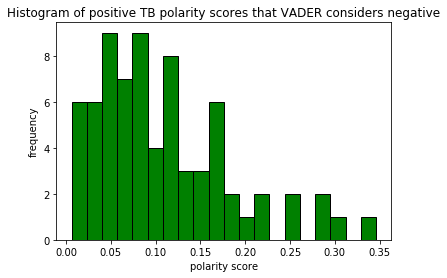

In [160]:
# matplotlib histogram
plt_data = sa_q1_sample[(sa_q1_sample.VDR_polarity == 'neg') & (sa_q1_sample.TB_polarity == 'pos')]

plt.hist(plt_data['TB_mean_SA_score'], color = 'green', edgecolor = 'black', bins=20)

# Add labels
plt.title('Histogram of positive TB polarity scores that VADER considers negative')
plt.xlabel('polarity score')
plt.ylabel('frequency')

plt.show()